In [33]:
import mido
from matplotlib import pyplot as plt
import numpy as np
import os
from math import sqrt

np.set_printoptions(suppress=True)

# Discriminator

In [2]:
import tensorflow as tf
from tensorflow import keras

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

print(tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[5], 'GPU')

# tf.compat.v1.disable_eager_execution()
tf.config.run_functions_eagerly(True)

2023-05-04 18:15:38.274936: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1
GPU available: 8


2023-05-04 18:15:39.445752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-04 18:15:39.574229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 18:15:39.576013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2023-05-04 18:15:39.576136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 18:15:39.577832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000

In [3]:
NOTES_QTY = 16
NOTE_PARAMS = 3
LATENT_DIM = 24

In [4]:
class MultiLayerAutoencoder(keras.Model):
    def __init__(self):
        super(MultiLayerAutoencoder, self).__init__()
        
        self.build_encoder()
        self.build_decoder()
        
    def build_encoder(self):        
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            
            keras.layers.Dense(64, activation='relu'), # 48x64 64x64 64x32 32x32
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'), 
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(LATENT_DIM, activation='tanh'),
        ])
        
    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.Input(shape=(LATENT_DIM)), # 32x32 32x64 64x64 64x48
            
            keras.layers.Dense(32, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            # keras.layers.Dropout(0.5),
            keras.layers.Dense(NOTES_QTY * NOTE_PARAMS, activation='linear'),
            
            keras.layers.Reshape((NOTES_QTY, NOTE_PARAMS))
        ])

    def call(self, x, training=True):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

In [5]:
autoencoder = MultiLayerAutoencoder()

test_out = autoencoder(np.zeros([1, 16, 3]), training=False)

2023-05-04 18:16:01.823163: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 18:16:01.834982: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2693670000 Hz
2023-05-04 18:16:01.839249: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2399700 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-04 18:16:01.839287: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-04 18:16:02.019458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retu

In [6]:
checkpoint = tf.train.Checkpoint(autoencoder=autoencoder)

PROJECT_PATH = '/raid/shumnov/music-style-performer/'
checkpoint_dir = PROJECT_PATH + 'train_data/ocgan_mlp_1/checkpoints'
checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [7]:
@tf.function
def predict(x):
    y = autoencoder(x)
    
    err = tf.math.square(x[..., 2] - y[..., 2])
    # err = tf.math.reduce_mean(err, axis=2)
    err = tf.math.reduce_mean(err, axis=1)
    
    err = tf.math.sqrt(err)
    
    return err

# Data

In [8]:
def Note(tone, time, duration, velocity, dt):
    return [tone, time, duration, velocity, dt]

In [9]:
def track2line(track):
    line = []

    time = 0
    for m in track:
        time += m.time

        if m.type == 'note_on' and m.velocity > 0:
            if len(line) > 0:
                line[-1][4] = time - line[-1][1]
            line.append(Note(m.note, time, -1, m.velocity, -1))
            
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            i = 1
            while line[-i][0] != m.note:
                i += 1
            
            line[-i][2] = time - line[-i][1]
            
    line[-1][4] = line[-1][2]
            
    return line


def split_line(line):
    lines = []
    prev = 0
    
    for i in range(1, len(line)):
        diff = line[i][1] - line[i - 1][1]
        
        if diff > 10000 or (line[i - 1][2] > 100 and line[i - 1][2] * 5 < diff):
            print(diff, line[i - 1][2])
            # if i - prev > LINE_MIN_LENGTH:
            lines.append(line[prev:i])
            lines[-1][-1][4] = lines[-1][-1][2]
                
            prev = i
            
    # if len(line) - prev > LINE_MIN_LENGTH:
    lines.append(line[prev:])
        
    return lines

def process_line(line):
    prev = line[0][0]
    line[0][0] = 0
    for i in range(1, len(line)):
        line[i][0] = line[i][0] - prev
        prev += line[i][0]

    line[..., 1] -= line[0][1]

In [10]:
params = (-0.0006052263335607262, 4.132044170275806, 5.560632707014063, 0.9528834736310532, 70.6449790510276, 15.86987401301365)

def normalize(notes, durs, vels, params=params):
    note_mean, note_std, dur_mean, dur_std, vel_mean, vel_std = params

    if notes is not None:
        notes = (notes - note_mean) / note_std    
    if durs is not None:
        print(durs)
        durs = tf.math.log(durs)
        print(durs)
        durs = (durs - dur_mean) / dur_std
        print(durs)
    if vels is not None:
        vels = (vels - vel_mean) / vel_std
    
    return notes, durs, vels

In [11]:
def graph_line(line):
    x = list(map(lambda x: x[1], line))
    y = list(map(lambda x: x[0], line))
    
    plt.plot(x, y, 'o-')
    plt.show()

In [12]:
mid1 = mido.MidiFile('satie.mid')
mid2 = mido.MidiFile('prokofiev.mid')

In [13]:
line = track2line(mid2.tracks[0])
np_line = np.array(line)
process_line(np_line)

notes = tf.convert_to_tensor(np_line[..., 0], dtype=tf.float32)
durs = tf.convert_to_tensor(np_line[..., 4], dtype=tf.float32)

durs /= 2.5

notes, durs, _ = normalize(notes, durs, None)

tf.Tensor(
[ 754.   590.   200.   362.   416.8  562.   175.2  384.   398.8  549.2
  202.   386.   372.   394.   392.   752.   374.   394.   784.   372.
  390.   784.   752.  1136.   400.   768.   576.   192.   384.   418.8
  543.2  188.8  385.2  404.8  537.2  216.   378.   376.   392.   384.
  748.   406.   386.   772.   376.   384.  1370. ], shape=(47,), dtype=float32)
tf.Tensor(
[6.6253924 6.3801227 5.2983174 5.8916445 6.0326066 6.331502  5.1659284
 5.9506426 5.98846   6.3084626 5.3082676 5.9558372 5.918894  5.976351
 5.971262  6.6227365 5.924256  5.976351  6.664409  5.918894  5.966147
 6.664409  6.6227365 7.035269  5.9914646 6.64379   6.3561077 5.2574954
 5.9506426 6.0373936 6.2974777 5.2406883 5.9537625 6.003393  6.2863703
 5.3752785 5.934894  5.9295893 5.971262  5.9506426 6.617403  6.0063534
 5.9558372 6.6489844 5.9295893 5.9506426 7.222566 ], shape=(47,), dtype=float32)
tf.Tensor(
[ 1.1174082   0.8600107  -0.27528578  0.34737906  0.49531123  0.8089858
 -0.414221    0.4092944   0.

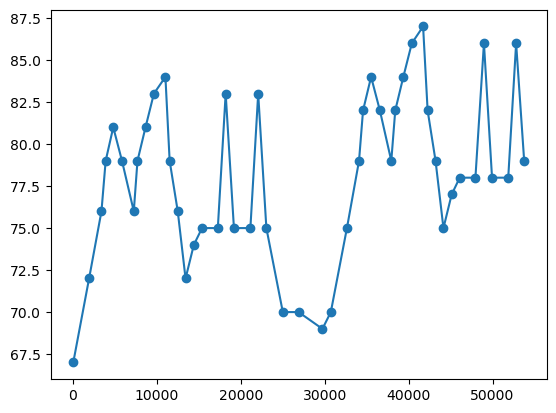

In [14]:
graph_line(line)

In [70]:
A = 0.05
B = 0
C = 1

In [71]:
@tf.function()
def style_loss(pred): 
    return 7 - tf.math.reduce_std(pred)
    # return tf.math.abs(tf.math.reduce_std(pred) - tf.math.reduce_std(style))

@tf.function()
def content_loss(pred):
    return 0
    # return tf.math.reduce_mean(tf.math.square(pred - content))

@tf.function()
def quality_loss(pred):
    loss = 0
    
    _, _, vels = normalize(None, None, pred)
    xline = tf.stack([notes, durs, vels], axis=1)
    
    for i in range(len(notes) - NOTES_QTY):
        x = tf.expand_dims(xline[i:i+NOTES_QTY], axis=0)
        loss += predict(x)[0] ** 2
        
    loss /= len(notes) - NOTES_QTY
    loss = tf.math.sqrt(loss)
    
    return loss

@tf.function()
def overall_loss(pred):
    return A * style_loss(pred) + B * content_loss(pred) + C * quality_loss(pred)

In [72]:
content = None
style = None

@tf.function()
def train_step(vel):    
    with tf.GradientTape() as tape:
        tape.watch(vel)
        loss = overall_loss(vel)

    grad = tape.gradient(loss, vel)
    opt.apply_gradients([(grad, vel)])
    
    return loss

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
sgd = tf.keras.optimizers.SGD()

In [75]:
start = np.random.normal(83, 0.1, (len(line)))

vel = tf.Variable(start, dtype=tf.float32)
vel
# vel = tf.Variable(np.array(line)[..., 3], dtype=tf.float32)

<tf.Variable 'Variable:0' shape=(47,) dtype=float32, numpy=
array([82.876076, 83.04145 , 83.01003 , 83.231544, 82.93578 , 82.88006 ,
       83.04694 , 83.0411  , 82.798096, 82.92649 , 82.868034, 82.76599 ,
       83.17125 , 83.087616, 83.07308 , 83.173   , 83.052666, 83.10314 ,
       83.14363 , 83.10745 , 83.034584, 83.11031 , 83.00673 , 83.049965,
       82.963356, 83.017876, 82.987045, 82.90028 , 83.03873 , 83.06818 ,
       82.960884, 82.87456 , 83.020615, 83.01508 , 82.76031 , 83.08383 ,
       83.09139 , 83.063995, 83.00202 , 82.93171 , 82.94093 , 82.957   ,
       83.15321 , 82.95045 , 83.00921 , 82.890594, 82.83995 ],
      dtype=float32)>

In [ ]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 200

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(vel)
    print(f"Step: {step} | style_loss: {style_loss(vel)} | quality_loss: {quality_loss(vel)}")

end = time.time()
print("Total time: {:.1f}".format(end-start))

Step: 200 | style_loss: 5.576166152954102 | quality_loss: 0.08331192284822464
Step: 400 | style_loss: 5.547534465789795 | quality_loss: 0.08357551693916321


In [ ]:
x = list(map(lambda x: x[1], line))
y = vel.numpy()

plt.plot(x, y, 'o-')
plt.show()

In [ ]:
i = 0

for m in mid2.tracks[0]:
    if m.type == 'note_on' and m.velocity > 0:
        m.velocity = int(vel[i])
        
        i += 1
        
mid2.save('result1.mid')